## Installation de quelques package

---
Enlever les commentaires pour installer les packages

In [1]:
# !pip install imojify emot emoji spacy contractions dash plotly

In [2]:
# !pip install jamspell textblob symspellpy wordcloud

In [3]:
# !python -m spacy download en_core_web_sm

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from wordcloud import WordCloud

from imojify import imojify
import emoji
import re
import pickle
from emot.emo_unicode import EMOJI_UNICODE, EMOTICONS_EMO, UNICODE_EMOJI, EMOJI_ALIAS_UNICODE, UNICODE_EMOJI_ALIAS

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split
import nltk
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
import re

import spacy
import jamspell
import symspellpy
from textblob import Word

# Charger le modèle de langue
nlp = spacy.load("en_core_web_sm")

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Acer Nitro
[nltk_data]     5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Acer Nitro
[nltk_data]     5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Acer Nitro 5\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
sns.set(style='ticks', palette='RdBu')
%matplotlib inline

## Chargement du jeu de données

In [9]:
df = pd.read_csv("../data/Amazon_Unlocked_Mobile.csv")
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


#### Description des attributs :

> Product Name - nom du produit, par exemple "Apple iPhone 5 16GB Factory unlocked GSM Cell Phone - White".

> Brand Name - nom de la marque.

> Price - Prix du produit

> Rating - Note donnée par l'utilisateur, entre 1 et 5

> Reviews  - Critique du produit donnée par l'utilisateur.

> Review Votes - Nombre de commentaires sur l'avis.


Nous allons adopter la démarches suivantes dans cette partie:
- Compréhension du jeu de données (ce notebook et celui sur les autres features)
- Etude statistique (ce notebook et celui sur les autres features)
- preprocessing (ce notebook)

In [10]:
df.shape

(413840, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [12]:
df.isnull().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

### 1. Prétraitement et redéfinition des variables

Nous allons faire une analyse de sentiment sur le jeu de données textuel nous n'avons donc pas besoin des colonnes 'Product Name', 'Brand Name', 'Price', 'Review Votes'

In [13]:
df.drop(['Product Name', 'Brand Name', 'Price', 'Review Votes'], axis=1, inplace=True)
df.head(5)

,Rating,Reviews
0,5,I feel so LUCKY to have found this used (phone...
1,4,"nice phone, nice up grade from my pantach revu..."
2,5,Very pleased
3,4,It works good but it goes slow sometimes but i...
4,4,Great phone to replace my lost phone. The only...


In [14]:
df.isnull().sum()

Rating      0
Reviews    62
dtype: int64

In [15]:
df.dropna(subset=['Reviews'], inplace=True)

> Separation en données d'entrainement et de test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Rating'], test_size=0.30, random_state=1, stratify=df['Rating'])
print("\t\t\t\t\t\t\t|\t\tX\t\t\t|\tY")
print("---" * 19)
print("taille entrainement: \t\t|", X_train.shape, "\t\t|", y_train.shape, "\ntaille test: \t\t\t\t|", X_test.shape,
      "\t\t|", y_test.shape, )

							|		X			|	Y
---------------------------------------------------------
taille entrainement: 		| (289644,) 		| (289644,) 
taille test: 				| (124134,) 		| (124134,)


In [17]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [18]:
train_data.reset_index(drop=True, inplace=True)

In [19]:
train_data.head()

,Reviews,Rating
0,The Classic is absolutly Not the same old Bold...,1
1,- NICE AND PRACTICAL- Basic but not cheap .- v...,4
2,The watch arrived on time and as promised so I...,2
3,I have been using the phone last one week and ...,5
4,This phone grabbed all the functions of the Sa...,5


Nous allons à présent prétraiter le texte à l'aide d'algorithmes de la bibliothèque NLTK et des expressions régulières

#### a. Expansion des contractions

Les contractions sont des mots ou des combinaisons de mots que l'on abrège en supprimant des lettres et en les remplaçant par une apostrophe.

Ex: I'm pour dire I am

ou encore

**Texte:** I'm hungry.I'd like eating some kebab.
**Après expansion:** I am hungry.I would like eating some kebab.

- Raisons de traiter les contractions en NLP

Il y a principalement deux raisons pour lesquelles il est judicieux de traiter les contractions en NLP.
> Premièrement, un ordinateur ne sait pas que les contractions sont des abréviations pour une séquence de mots. Par conséquent, un ordinateur considère que we're et we are sont deux choses complètement différentes et ne reconnaît pas que ces deux termes ont exactement la même signification.
>
> Deuxièmement, les contractions augmentent la dimensionnalité de la matrice document-terme (par exemple, nous avons une colonne pour le terme we are et une colonne pour le terme we're). Cette augmentation de la dimensionnalité rend le calcul plus coûteux.

Il est donc logique d'aider un peu notre ordinateur et de lui apprendre que les contractions ne sont que des combinaisons de mots. Cela profite à la fois à l'ordinateur, qui doit travailler moins dur, et à nous, car nous ne devons pas attendre si longtemps !

In [20]:
import contractions


def expand_contractions(text):
    return contractions.fix(text)

appliquer au dataframe

In [21]:
train_data["Reviews"] = train_data["Reviews"].apply(expand_contractions)
test_data["Reviews"] = test_data["Reviews"].apply(expand_contractions)

In [22]:
train_data.sample(5)

,Reviews,Rating
247488,It is an awesome phone. The edge takes a littl...,5
200694,"Prompt delivery,good price,no problems or issues.",5
267330,"Look, I know they are not exactly new, but thi...",1
76254,"Everything was perfect, the phone is in perfec...",5
164884,Well when i got it it looked new and it has no...,4


#### b. Gestion des charactères spéciaux (émojis, émoticons ..)

Les emoji et les émoticônes véhiculent une expression émotionnelle dans un message texte. Pour l'analyse de texte, nous devons les manipuler avec précaution. Nous pouvons les traiter de deux façons:
> 1. En les supprimant simplement: Supprimer les emojis/emoticons du texte pour l'analyse de texte n'est pas forcément une bonne décision. Parfois, ils peuvent fournir des informations importantes sur un texte, comme l'expression d'un sentiment, notamment dans l'analyse des sentiments, et leur suppression n'est pas forcément la bonne solution.
>>> Ex: J'❤ ce livre, par contre le personnage est trop 👌

>> Dans cette exemple si on enlève les émoji le sentiment de la phrase risque de changer

> 2. Comme nous l'avons vu dans l'exemple ci-dessus, le remplacement peut être la bonne décision car les emojis/emoticons peuvent donner des indications utiles sur les textes. Par conséquent, nous pouvons les convertir en format word afin qu'ils puissent être utilisés dans les processus de modélisation.

Nous allons utiliser les bibliothèques **emot** et **emoji** pour traiter les emojis/emoticons

In [23]:
def extract_emojis(s):
    res = []
    for c in s:
        if emoji.is_emoji(c):
            res.append(c)
    if len(res) != 0:
        return res
    else:
        return

In [24]:
train_data["detected_emoji"] = train_data["Reviews"].apply(extract_emojis)

In [25]:
test_data["detected_emoji"] = test_data["Reviews"].apply(extract_emojis)

In [26]:
# recuperer tout les emojis détecté
all_emoji = res = list(filter(lambda item: item is not None, train_data["detected_emoji"].to_list()))
# aplatir la liste
all_emoji_merged = list(itertools.chain(*all_emoji))

In [27]:
# compter les occurrences
all_emoji_by_occ = dict(Counter(all_emoji_merged))


In [28]:
# mettre dans un dataframe
emoji_df = pd.DataFrame(all_emoji_by_occ.items(), columns=['Emoji', 'Count'])
emoji_df.head()

,Emoji,Count
0,😊,293
1,❤,155
2,😁,82
3,😳,13
4,😀,148


In [29]:
# trions les données
emoji_df.sort_values(by="Count", inplace=True, ascending=False, ignore_index=True)
emoji_df.head(10)

,Emoji,Count
0,👍,707
1,😊,293
2,😍,201
3,😡,196
4,👌,171
5,❤,155
6,😀,148
7,🏻,124
8,👎,101
9,☺,98


Histogramme des emojis les plus fréquemment utilisés

In [30]:
N = 10
top_10_emojis = emoji_df.head(N)

In [31]:
values = top_10_emojis["Count"].to_list()
emojis = top_10_emojis["Emoji"].to_list()

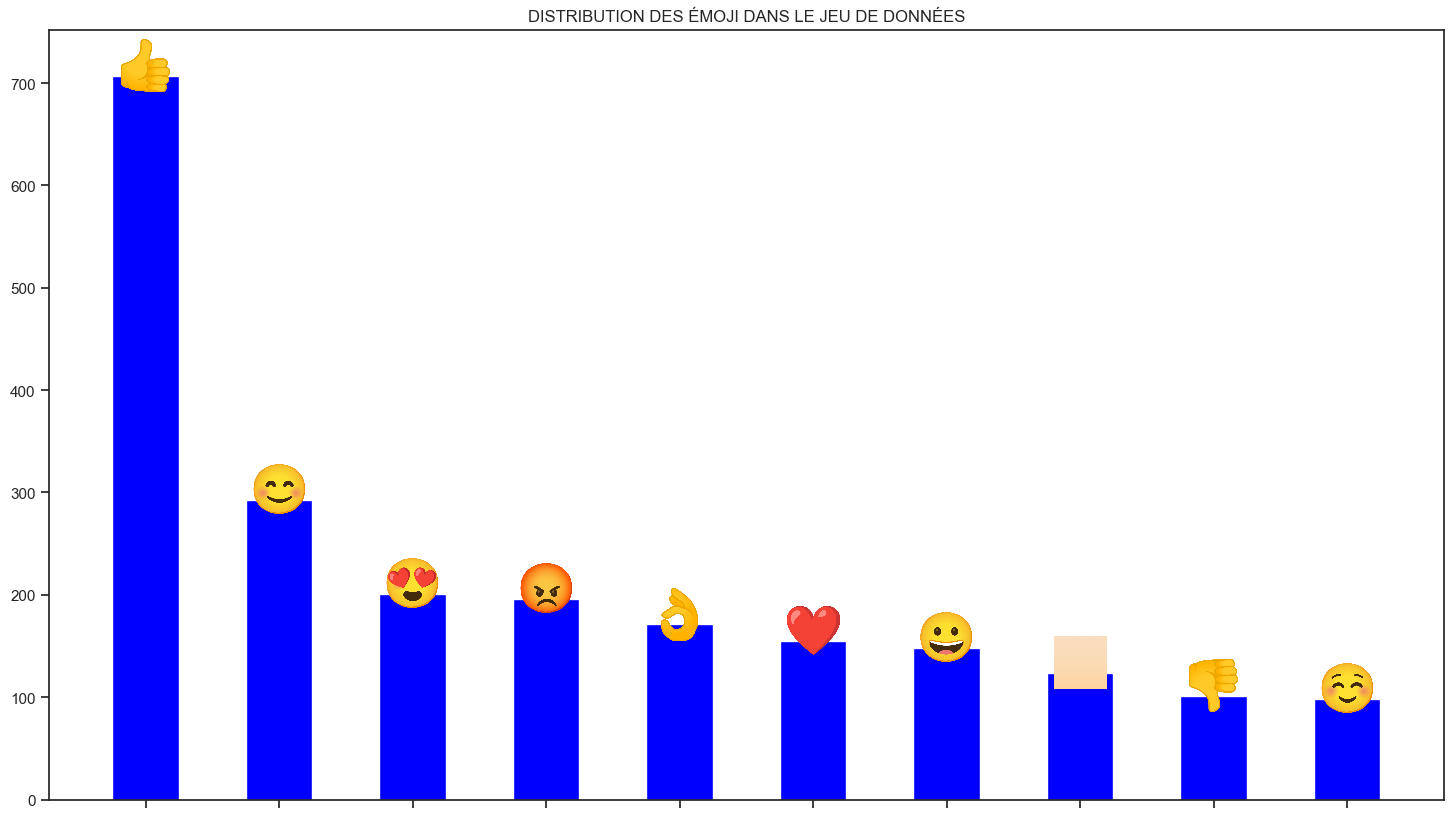

In [32]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(range(N), values, width=0.5, align="center", color="blue")
ax.set_xticks(range(N))
ax.set_xticklabels([])
ax.tick_params(axis='x', which='major', pad=26)
ax.set_ylim((0, ax.get_ylim()[1] + 10))
ax.set_title("DISTRIBUTION DES ÉMOJI DANS LE JEU DE DONNÉES")


def offset_image(cords, emoji, ax):
    img = plt.imread(imojify.get_img_path(emoji))
    im = OffsetImage(img, zoom=0.08)
    im.image.axes = ax
    ab = AnnotationBbox(im, (cords[0], cords[1]), frameon=False, pad=1)
    ax.add_artist(ab)


for i, e in enumerate(emojis):
    offset_image([i, values[i] + 10], e, ax)

chargement du dictionnaire des emojis et des emoticones

In [33]:
with open('../data/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

with open('../data/Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

In [34]:
def convert_emojis_and_emoticons_to_word(text):
    # remove emoticons
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    text = emoticon_pattern.sub(r'', text)
    # replace emoji
    text = emoji.demojize(text).replace(",", "").replace(":", "").strip()
    return " ".join(text.split())

In [35]:
convert_emojis_and_emoticons_to_word("Hello :-) :-) I ❤ you")

'Hello I red_heart you'

In [36]:
train_data["Reviews"] = train_data["Reviews"].apply(convert_emojis_and_emoticons_to_word)

In [37]:
test_data["Reviews"] = test_data["Reviews"].apply(convert_emojis_and_emoticons_to_word)

In [38]:
train_data.head()

,Reviews,Rating,detected_emoji
0,The Classic is absolutly Not the same old Bold...,1,None
1,- NICE AND PRACTICAL- Basic but not cheap .- v...,4,None
2,The watch arrived on time and as promised so I...,2,None
3,I have been using the phone last one week and ...,5,None
4,This phone grabbed all the functions of the Sa...,5,None


In [39]:
# verification
train_data["detected_emoji"] = train_data["Reviews"].apply(extract_emojis)
test_data["detected_emoji"] = test_data["Reviews"].apply(extract_emojis)

In [40]:
train_data.isnull().sum()

Reviews                0
Rating                 0
detected_emoji    289644
dtype: int64

Nous avons maintenant un text sans emoji ni emoticons

In [41]:
# remove detected_emoji
train_data.drop(columns="detected_emoji", axis=1, inplace=True)
test_data.drop(columns="detected_emoji", axis=1, inplace=True)

#### c. Tokenisation

![iamge tokenisation](https://miro.medium.com/max/1050/0*EKgminT7W-0R4Iae.png)

La tokenisation est utilisée dans le traitement du langage naturel pour diviser les paragraphes et les phrases en unités plus petites auxquelles on peut plus facilement attribuer une signification.

La première étape du processus NLP consiste à rassembler les données (une phrase) et à les décomposer en parties compréhensibles (mots). Voici un exemple de chaîne de données :

*"Quels sont les restaurants à proximité ?"*

Pour que cette phrase puisse être comprise par une machine, une tokénisation est effectuée sur la chaîne de caractères afin de la décomposer en éléments individuels. Avec la tokénisation, on obtiendrait quelque chose comme ça :

*"quels" "restaurants" "sont" "à proximité".*

---
Cela peut sembler simple, mais décomposer une phrase en ses parties permet à une machine de comprendre les parties aussi bien que le tout. Cela aidera le programme à comprendre chacun des mots en soi, ainsi que la façon dont ils fonctionnent dans un texte plus large. C'est particulièrement important pour les grandes quantités de texte, car cela permet à la machine de compter la fréquence de certains mots et de savoir où ils apparaissent fréquemment. Ceci est important pour les étapes ultérieures du traitement du langage naturel.

In [42]:
def tokenization(text):
    text = re.sub(r'www', 'https', text)
    text = re.sub(r'http[^\s]+', '', text)
    text = re.sub('@[^\s]+', '', text)
    tokenizer = RegexpTokenizer("[a-zA-Z]+", discard_empty=True)
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text.lower()


train_data['Reviews'] = train_data['Reviews'].apply(tokenization)
test_data["Reviews"] = test_data["Reviews"].apply(tokenization)

In [43]:
train_data.head()

,Reviews,Rating
0,the classic is absolutly not the same old bold...,1
1,nice and practical basic but not cheap very re...,4
2,the watch arrived on time and as promised so i...,2
3,i have been using the phone last one week and ...,5
4,this phone grabbed all the functions of the sa...,5


#### d. Stopwords

Les mots d'arrêt sont les mots les plus courants de toute langue naturelle. Dans le cadre de l'analyse des données textuelles et de la construction de modèles NLP, ces mots d'arrêt peuvent ne pas ajouter beaucoup de valeur à la signification du document.

En général, les mots les plus courants utilisés dans un texte sont 'the', 'a', 'of' etc.

---
Ils peuvent être supprimés du texte la plupart du temps, car ils ne fournissent pas d'informations précieuses pour l'analyse en aval. Dans des cas comme le marquage des parties du discours (POS tagging), nous ne devrions pas les supprimer car ils fournissent des informations très précieuses sur le POS. Ces listes de mots vides sont déjà compilées pour différentes langues et nous pouvons les utiliser en toute sécurité. Par exemple, la liste de mots vides pour la langue anglaise du paquet nltk peut être vue ci-dessous.



In [44]:
stop_words = ['yourself', 'yourselves', 'herself', 'themselves',
              'himself', 'ourselves',
              'myself', 'between', 'whom', 'is', "she", 'here', 'your', 'each', 'we', 'he',
              'my', 'you', 'are', 'them', 'other', 'and', 'an', 'their', 'can', 'she', 'these',
              'ours', 'while', 'have', 'when', 'were', 'who', 'they', 'has', 'before', 'yours',
              "it", 'on', 'now', 'her', 'an', 'from', "would", 'how', 'the', 'or', 'doing',
              'his', 'was', 'through', 'own', 'theirs', 'me', 'him', 'be', 'same', 'it', 'its',
              'which', 'there', 'our', 'this', 'hers', 'being', 'did', 'those', 'i', 'does', 'will',
              'shall', 's', 't', 'n', 'd', 'e', 'u', 'x', 'am', 'get', 've']
# Nous avons préparé une liste en ajoutant manuellement des
# alphabets (comme S,G,T etc. car ils désignent le modèle du produit
# comme dans Samsung Galaxy S, i phone X12, Motorola E2 etc).

In [45]:
def remove_stop_words(text):
    res = []
    for w in text.split():
        if w not in stop_words:
            res.append(w)
    return " ".join(res)[:-1]

In [46]:
train_data["Reviews"] = train_data["Reviews"].apply(remove_stop_words)
test_data["Reviews"] = test_data["Reviews"].apply(remove_stop_words)

In [47]:
# check if no null
train_data.isnull().sum()

Reviews    0
Rating     0
dtype: int64

In [48]:
test_data.isnull().sum()

Reviews    0
Rating     0
dtype: int64

In [49]:
train_data.head()

,Reviews,Rating
0,classic absolutly not old bold that gave up to...,1
1,nice practical basic but not cheap very resist...,4
2,watch arrived time as promised so extremely ha...,2
3,been using phone last one week loving camera w...,5
4,phone grabbed all functions of samsung note th...,5


#### e. Correction d'orthographe

![spelling](https://user-images.githubusercontent.com/22280243/82138959-2852cd00-9842-11ea-918a-49b2a7873ef6.png)

Dans le domaine du traitement du langage naturel, il est important que les fautes d'orthographe soient aussi rares que possible, afin que tout ce que nous faisons soit très précis. Il existe des bibliothèques qui se chargent de cette tâche fastidieuse, au lieu de vous laisser faire toute la vérification et la correction.

Nous utiliserons la distance de Levenshtein, la distance de Hamming, Needleman-Wunsch pour vérifier la précision du résultat.

---
Bibliothèques que nous utiliserons :

- **Jamspell** ```pip install jamspell``` est une bibliothèque de correction orthographique moderne. Elle est légère, rapide et précise. Elle prend en compte l'environnement des mots pour effectuer de meilleures corrections. Il a les caractéristiques suivantes :
Il considère l'environnement des mots (contexte) pour mieux les corriger.
Près de 5000 mots par seconde
Multi-langue → il est écrit en C++ et disponible pour de nombreuses langues avec des bindings swig.
- **Symspellpy** ```pip install symspellpy``` L'algorithme de correction orthographique Symmetric Delete réduit la complexité de la génération de candidats à l'édition et de la consultation du dictionnaire pour une distance Damerau-Levenshtein donnée. Il est six ordres de grandeur plus rapide (que l'approche standard avec suppressions + transpositions + remplacements + insertions) et indépendant de la langue. Un mot moyen de 5 lettres comporte environ 3 millions de fautes d'orthographe possibles dans une distance d'édition maximale de 3, mais SymSpell n'a besoin de générer que 25 suppressions pour les couvrir toutes, à la fois lors du précalcul et lors de la recherche.
- **Textblob** ```pip install textblob``` La correction orthographique de textblob est basée sur "How to Write a Spelling Corrector" de Peter Norvig, tel qu'implémenté dans la bibliothèque de motifs.

**NB:** Nous avons déjà installé les librairies en début du notebook

In [50]:
class RepeatReplacer(object):

    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'

    def replace(self, word):
        if wordnet.synsets(word):
            return word

        repl_word = self.repeat_regexp.sub(self.repl, word)

        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word

In [51]:
# Charger le modèle de correction d'orthographe de JamSpell
spell_checker = jamspell.TSpellCorrector()
# instancier le modèle de remplacement de caractère répété
replacer = RepeatReplacer()
# Charger le modèle de correction d'orthographe de SymSpellPy
sym_spell = symspellpy.SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary('../data/english_words_frequency.txt', term_index=0, count_index=1)


True

In [52]:
def correct_spelling(text):
    # Corriger l'orthographe du texte avec JamSpell
    corrected_text = spell_checker.FixFragment(text)

    # Splitter le texte en tokens
    tokens = corrected_text.split()

    # Corriger l'orthographe de chaque token avec SymSpellPy
    corrected_tokens = []
    for token in tokens:
        correction = sym_spell.lookup(token, symspellpy.Verbosity.ALL, max_edit_distance=2, include_unknown=False)

        if len(correction) == 0:
            text = replacer.replace(token)
            # si le mot n'est toujours pas présent on le saute
            correction = sym_spell.lookup(text, symspellpy.Verbosity.ALL, max_edit_distance=2, include_unknown=True)

        if len(correction) > 0:
            corrected_token = correction[0].term
            corrected_tokens.append(corrected_token)

    # Rejoindre les tokens corrigés en une chaîne de caractères
    corrected_text = ' '.join(corrected_tokens)

    # Corriger l'orthographe du texte avec TextBlob
    corrected_text = str(Word(corrected_text).correct())

    return corrected_text

In [53]:
text = "i really lov this kinda mommmmmmmentttt bro!"
print(correct_spelling(text))

i really love this kinda moment bro


#### f. Lemmatisation

![Lemmatisation](https://d2mk45aasx86xg.cloudfront.net/Example_to_understand_lemmatization_a73d97a04c.webp)

Les langues telles que l'anglais et le francais sont composées de plusieurs mots qui sont souvent dérivés les uns des autres. En outre, une langue infléchie est un terme utilisé pour une langue qui contient des mots dérivés. Par exemple, le mot "historique" est dérivé du mot "histoire" et est donc un mot dérivé.

Il existe toujours une forme de racine commune pour tous les mots infléchis. De plus, le degré d'inflexion varie de faible à élevé selon la langue.

Pour résumer, la forme racine des mots dérivés ou infléchis est obtenue en utilisant le stemming et la lemmatisation.

![StemmingVSlemmatization](https://lh3.googleusercontent.com/3wumK8lGLhKpD2Fhbu35I7wWf6OSpF_erX9T7FX9WQCE5_HBKMJpKOZNximlzlTG5882QUWcL-_lFLJd0-RIo4uHDaO7cK8aEnw2Tm2-5xPwjYS3ls6fYefeGAVGb1WUGrXafJrC)


La lemmatisation et le stemming, toutes deux sont utilisées pour générer la forme racine des mots dérivés (infléchis). Cependant, le lemme est un mot réel de la langue, alors que le radical peut ne pas être un mot réel.

---
Pour la lemmatisation, on peut utiliser soit spaCy soit NLTK. Ces deux bibliothèques de traitement du langage naturel sont populaires et offrent des fonctionnalités de lemmatisation de haute qualité.

Voici quelques points à prendre en compte pour choisir entre spaCy et NLTK :

* **Performance :** spaCy est connu pour ses performances rapides et est souvent utilisé pour les tâches de traitement du langage naturel en temps réel. NLTK est moins rapide, mais peut toujours être utilisé pour des tâches de lemmatisation de manière efficace.

* **Facilité d'utilisation :** spaCy est conçu pour être simple à utiliser et offre une interface utilisateur intuitive. NLTK est plus complexe à utiliser et peut être plus difficile à apprendre pour les débutants.

* **Fonctionnalités :** spaCy offre une gamme complète de fonctionnalités de traitement du langage naturel, y compris la lemmatisation. NLTK offre également une large gamme de fonctionnalités, mais peut être moins complet que spaCy dans certains domaines.

> Nous allons utiliser spaCy pour faire la lemmatisation

In [57]:
def lemmatize_text(text):
    # Tokeniser le texte en mots
    words = word_tokenize(text)

    # Initialiser le lemmatiseur
    lemmatizer = WordNetLemmatizer()

    # Lemmatiser chaque mot
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Rejoindre les mots lemmatisés en une chaîne de caractères
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

In [58]:
train_data["Reviews"] = train_data["Reviews"].apply(lemmatize_text)
test_data["Reviews"] = test_data["Reviews"].apply(lemmatize_text)

In [60]:
train_data.head()

,Reviews,Rating
0,classic absolutly not old bold that give up to...,1
1,nice practical basic but not cheap very resist...,4
2,watch arrive time a promise so extremely happy...,2
3,be use phone last one week love camera working...,5
4,phone grab all function of samsung note then t...,5


> <h3>Fonction de preprocessing</h3>

In [61]:
def preprocessReview(review):
    # expansion des contractions
    expanded_r = expand_contractions(review)
    # remplacement des emojis par leur sens textuel
    emoji_r = convert_emojis_and_emoticons_to_word(expanded_r)
    # tokenization
    tokenized_r = tokenization(emoji_r)
    # suppression des mots d'arret
    removed_stop_w_r = remove_stop_words(tokenized_r)
    # lemmatization du texte
    lemmatized_r = lemmatize_text(removed_stop_w_r)
    return lemmatized_r

### 2. Statistiques sur les données prétraitées

In [62]:
train_data["nombre-mots-reviews"] = train_data["Reviews"].apply(lambda s: len(s.split()))
train_data["longueur-reviews"] = train_data["Reviews"].apply(lambda s: len(s))

In [63]:
test_data["nombre-mots-reviews"] = test_data["Reviews"].apply(lambda s: len(s.split()))
test_data["longueur-reviews"] = test_data["Reviews"].apply(lambda s: len(s))

In [64]:
train_data.head()

,Reviews,Rating,nombre-mots-reviews,longueur-reviews
0,classic absolutly not old bold that give up to...,1,176,936
1,nice practical basic but not cheap very resist...,4,14,80
2,watch arrive time a promise so extremely happy...,2,108,571
3,be use phone last one week love camera working...,5,294,1630
4,phone grab all function of samsung note then t...,5,41,216


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


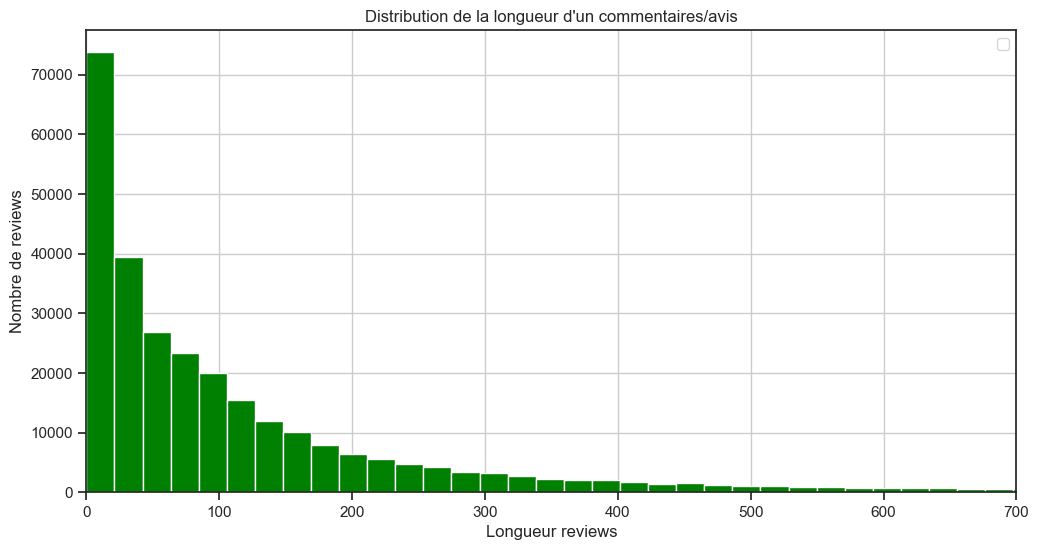

In [65]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 1000
plt.hist(train_data['longueur-reviews'], facecolor='green', alpha=1, bins=bins)
plt.title('Distribution de la longueur d\'un commentaires/avis')
plt.xlabel('Longueur reviews')
plt.ylabel('Nombre de reviews')
plt.legend(loc='upper right')
plt.xlim(0,700)
plt.grid(True)
plt.show()

La plupart des longueurs d'examen se situent entre 0 et 300. Il serait préférable de prendre en compte les revues ayant une longueur <= 300 car cela nous aidera à obtenir des vecteurs de caractéristiques moins épars et nous fera gagner beaucoup d'espace mémoire.

In [66]:
print("Pourcentage de reviews avec une longueur > 300: {}%".format(round(len(train_data[train_data['longueur-reviews'] > 300])*100/len(train_data), ndigits=2)))

Pourcentage de reviews avec une longueur > 300: 12.43%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


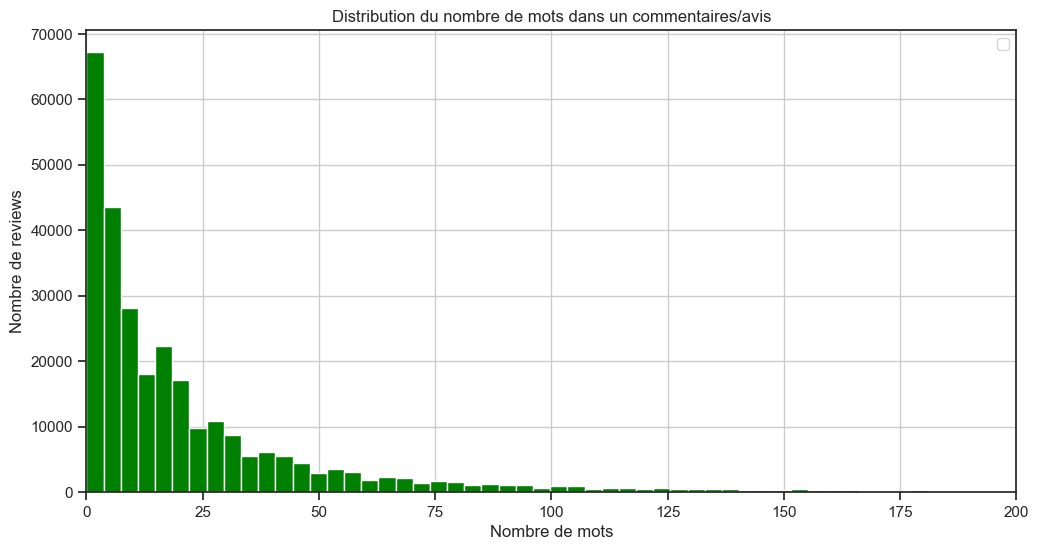

In [67]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 1000
plt.hist(train_data['nombre-mots-reviews'], facecolor='green', alpha=1, bins=bins)
plt.title('Distribution du nombre de mots dans un commentaires/avis')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de reviews')
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.grid(True)
plt.show()

La plupart des reviews contiennent moins de 100 mots.

---

Par ailleurs il est inutile de garder des reviews avec un nombre de mots egal à zero.
Nous allons donc enlever les reviews ne contenant aucun mots

In [68]:
print("ENSEMBLE ENTRAINEMENT")
print(train_data[train_data['nombre-mots-reviews'] == 0].count())
train_data.drop(train_data[train_data['nombre-mots-reviews'] == 0].index , inplace = True)

ENSEMBLE ENTRAINEMENT
Reviews                464
Rating                 464
nombre-mots-reviews    464
longueur-reviews       464
dtype: int64


In [69]:
print("ENSEMBLE TEST")
print(test_data[test_data['nombre-mots-reviews'] == 0].count())
test_data.drop(test_data[test_data['nombre-mots-reviews'] == 0].index , inplace = True)

ENSEMBLE TEST
Reviews                217
Rating                 217
nombre-mots-reviews    217
longueur-reviews       217
dtype: int64


#### Nuage de mots ensemble entrainement

In [70]:
# discrimination des reviews
negative = train_data[train_data.Rating<3]
positive = train_data[train_data.Rating>=3]

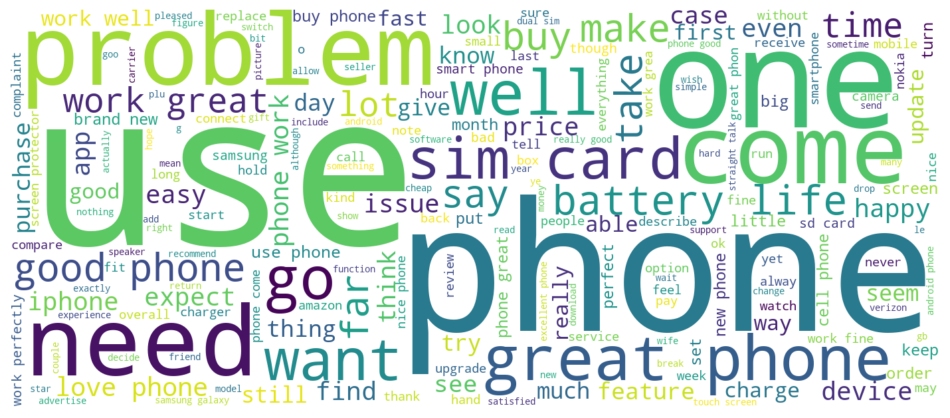

In [71]:
# nuage de mots des reviews positf

# concaténation de tous les reviews en un seul texte
text = " ".join(review for review in positive["Reviews"])

# création du nuage de mots avec Wordcloud
wordcloud = WordCloud(background_color="white",width=1400, height=600).generate(text)

# affichage du nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

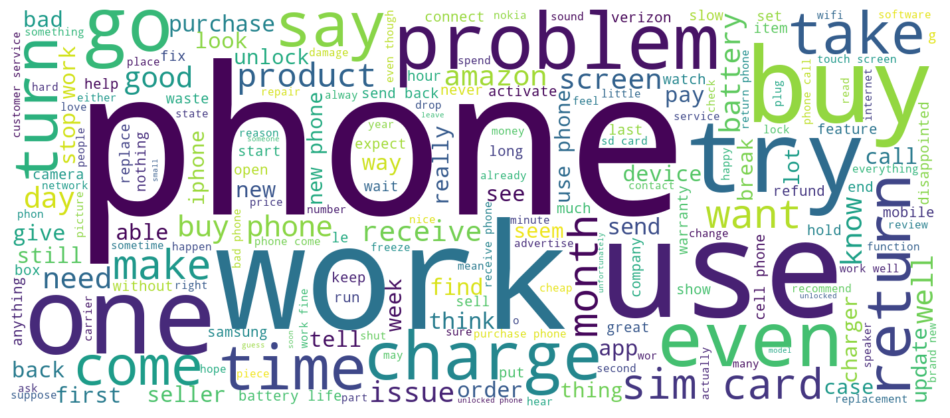

In [72]:
# nuage de mots des reviews negatifs

# concaténation de tous les reviews en un seul texte
text = " ".join(review for review in negative["Reviews"])

# création du nuage de mots avec Wordcloud
wordcloud = WordCloud(background_color="white",width=1400, height=600).generate(text)

# affichage du nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Analyse N-gram

In [73]:
from nltk import ngrams


import pandas as pd
from collections import Counter
from nltk import ngrams

def generate_ngrams(documents, n):
    # Initialiser une liste vide pour stocker tous les n-grammes
    ngrams_all = []

    # Pour chaque document de la liste
    for document in documents:
        # Séparer le document en mots
        document = document.split()

        # Si le document est trop court pour contenir au moins un n-gramme, passer au document suivant
        if len(document) < n:
            continue
        # Sinon, extraire les n-grammes du document
        else:
            output = list(ngrams(document, n))

        # Ajouter chaque n-gramme à la liste
        for ngram in output:
            ngrams_all.append(" ".join(ngram))

    # Compter le nombre d'occurrences de chaque n-gramme dans la liste
    count_ngram = Counter()
    for word in ngrams_all:
        count_ngram[word] += 1

    # Créer un DataFrame à partir de ces comptes
    df = pd.DataFrame.from_dict(count_ngram, orient='index').reset_index()

    # Renommer les colonnes du DataFrame
    df = df.rename(columns={'index':'words', 0:'count'})

    # Trier le DataFrame par ordre décroissant de compte
    df = df.sort_values(by='count', ascending=False)

    # Sélectionner les 25 n-grammes les plus fréquents
    df = df.head(25)

    # Trier le DataFrame par ordre croissant de compte
    df = df.sort_values(by='count')

    # Renvoyer le DataFrame
    return df

def plot_ngrams(documents):
    # Générer des n-grammes de différentes tailles
    unigrams = generate_ngrams(documents, 1)
    bigrams = generate_ngrams(documents, 2)
    trigrams = generate_ngrams(documents, 3)

    # Créer une figure
    fig = plt.figure(figsize = (20, 7))
    plt.subplots_adjust(wspace=.5)

    # Ajouter un premier sous-plot pour les unigrammes
    ax = fig.add_subplot(131)
    # Tracer un histogramme des comptes d'unigrammes
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=1)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')

    # Ajouter un deuxième sous-plot pour les bigrammes
    ax2 = fig.add_subplot(132)
    # Tracer un histogramme des comptes de bigrammes
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=1, color = 'red')
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')

    # Ajouter un troisième sous-plot pour les trigrammes
    ax3 = fig.add_subplot(133)
    # Tracer un histogramme des comptes de trigrammes
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=1, color = 'green')
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    # Afficher la figure
    plt.show()

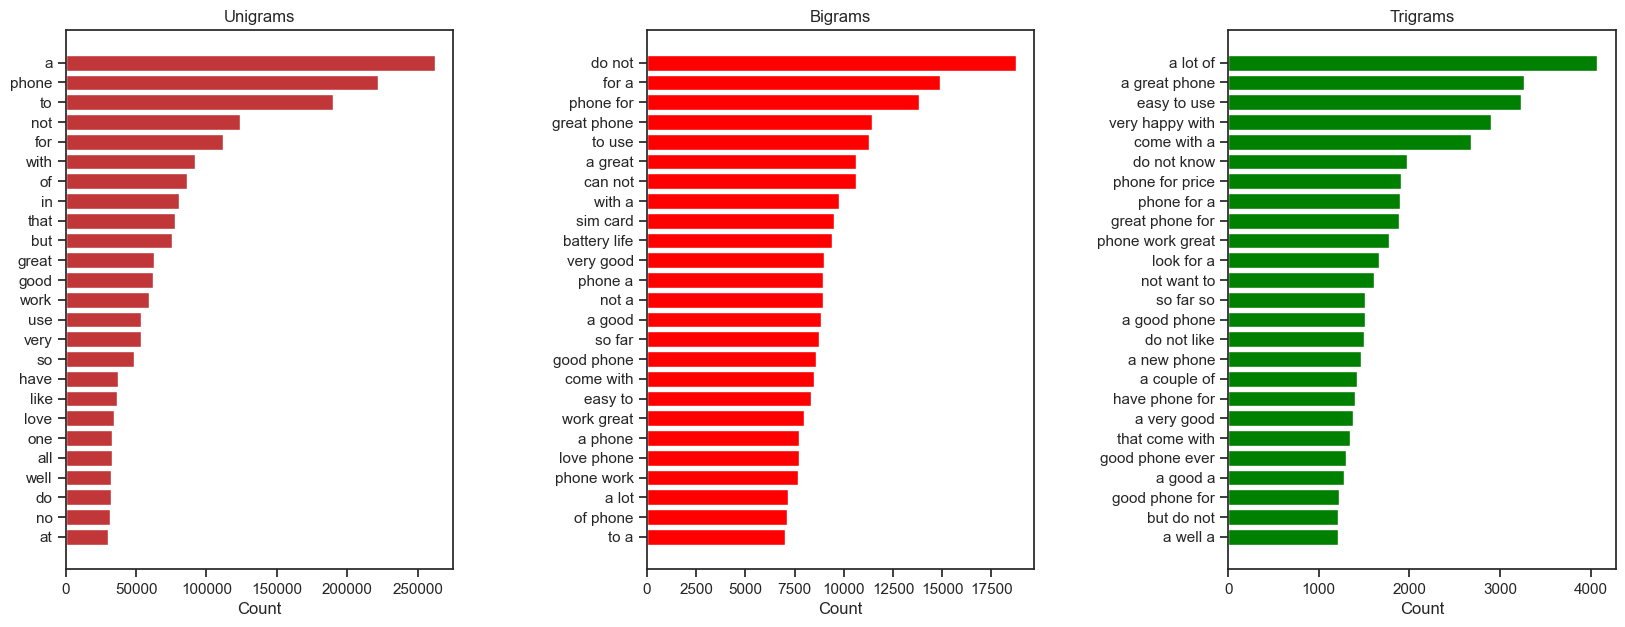

In [74]:
plot_ngrams(positive.Reviews)

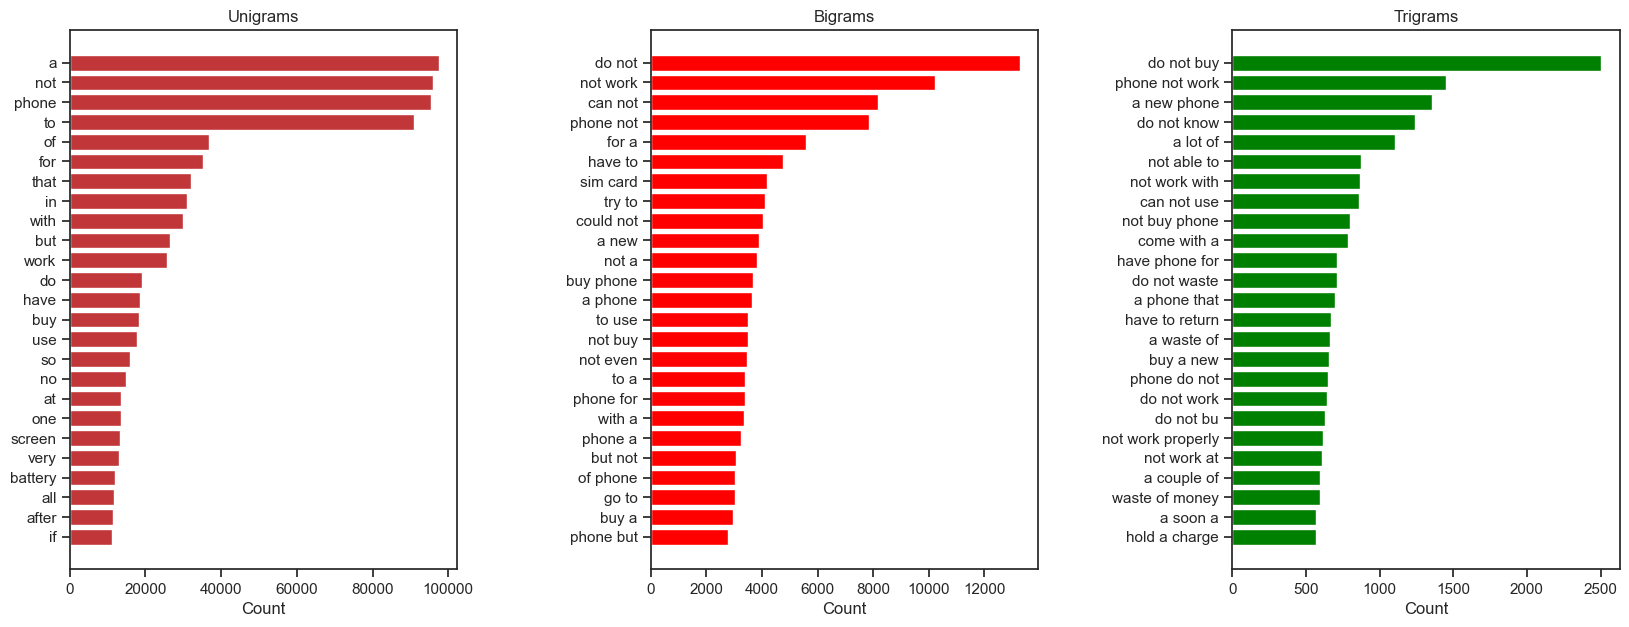

In [75]:
plot_ngrams(negative.Reviews)

#### SAVE PREPROCESSED DATA

In [81]:
# on enleve les reviews de longueur inferieur à 250 caractères
index_names_train = train_data[train_data['longueur-reviews'] > 250].index
index_names_test = test_data[test_data['longueur-reviews']>250].index
train_data.drop(index_names_train, inplace=True)
test_data.drop(index_names_test, inplace=True)

In [82]:
train_data.shape

(244204, 4)

In [83]:
test_data.shape

(103856, 4)

In [84]:
train_data.to_csv("../data/train_data.csv", index=False)
test_data.to_csv("../data/test_data.csv", index=False)